## Libraries

In [1]:
import itertools
import glob
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.utils  import to_categorical
import keras
from keras.preprocessing import image
from keras.applications import MobileNetV2
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator



from keras.applications import DenseNet121

## Dataset Preparation
Since the datasets I found on the web were relatively small, I merged several of them together to form one larger dataset.

## Train data

In [2]:
def load_images(folder, cats):
    X_train = []
    y_train = []
    i = 0
    for f in folder:
        path_png = './dataset/train/'+ f +'/*.png'
        path_jpg = './dataset/train/'+ f +'/*.jpg'
    
        print('loading training dataset ' + f + '...')
        
        for filename in itertools.chain(glob.glob(path_jpg), glob.glob(path_png)):
            try:
                im = cv2.imread(filename)
                if im is None:
                    raise Exception("Could not read image file: " + filename)
            except Exception as e:
                print("[ERROR] " + str(e))
                continue

            img_resized = cv2.resize(im, (128, 128), interpolation=cv2.INTER_AREA)
            
            X_train.append(img_resized)
            y_train.append(cats[i])
            
        i = (i + 1) % len(cats)
    
    return X_train, y_train

def process_images(X_train, y_train):
    w, h = X_train[0].shape[:2]
    X_train = np.array([im.reshape(w*h, 3) for im in X_train])
    X_train = X_train/255.0
    
    y_train = np.array(y_train).astype(int)
    y_train = y_train.reshape(len(y_train), 1)
    y_train=to_categorical(y_train)
    
    return X_train, y_train

def run_image_processing():
    folder = ['freshapples', 'freshbanana', 'freshoranges','freshlime', 'rottenapples', 'rottenbanana','rottenoranges','rottenlime']
    cats = ['0', '1', '2', '3', '4', '5','6','7']
    X_train, y_train = load_images(folder, cats)
    X_train, y_train = process_images(X_train, y_train)
    
    return X_train, y_train

X_train, y_train = run_image_processing()

loading training dataset freshapples...
loading training dataset freshbanana...
loading training dataset freshoranges...
loading training dataset freshlime...
loading training dataset rottenapples...
loading training dataset rottenbanana...
loading training dataset rottenoranges...
loading training dataset rottenlime...


## Test Data

In [3]:
def load_images(folder, cats):
    X_test = []
    y_test = []
    i = 0
    for f in folder:
        path_png = './dataset/test/'+ f +'/*.png'
        path_jpg = './dataset/test/'+ f +'/*.jpg'
    
        print('loading testing dataset ' + f + '...')
        
        for filename in itertools.chain(glob.glob(path_jpg), glob.glob(path_png)):
            try:
                im = cv2.imread(filename)
                if im is None:
                    raise Exception("Could not read image file: " + filename)
            except Exception as e:
                print("[ERROR] " + str(e))
                continue

            img_resized = cv2.resize(im, (128, 128), interpolation=cv2.INTER_AREA)
            
            X_test.append(img_resized)
            y_test.append(cats[i])
            
        i = (i + 1) % len(cats)
    
    return X_test, y_test

def process_images(X_test, y_test):
    w, h = X_test[0].shape[:2]
    X_test = np.array([im.reshape(w*h, 3) for im in X_test])
    X_test = X_test/255.0
    
    y_test = np.array(y_test).astype(int)
    y_test = y_test.reshape(len(y_test), 1)
    y_test=to_categorical(y_test)
    
    return X_test, y_test

def run_image_processing():
    folder = ['freshapples', 'freshbanana', 'freshoranges','freshlime', 'rottenapples', 'rottenbanana','rottenoranges','rottenlime']
    cats = ['0', '1', '2', '3', '4', '5','6','7']
    X_test, y_test = load_images(folder, cats)
    X_test, y_test = process_images(X_test, y_test)
    
    return X_test, y_test

X_test, y_test = run_image_processing()



loading testing dataset freshapples...
loading testing dataset freshbanana...
loading testing dataset freshoranges...
loading testing dataset freshlime...
loading testing dataset rottenapples...
loading testing dataset rottenbanana...
loading testing dataset rottenoranges...
loading testing dataset rottenlime...


- Check categorical labels 
- Check data shape

In [9]:
print('Categorical labels: \n',y_train)
print('\nCategorical labels dtype: ',y_train.dtype)

#reshape
X_train = X_train.reshape(X_train.shape[0], 128, 128, 3)
X_test = X_test.reshape(X_test.shape[0], 128, 128, 3)

print('\nX_train shape:', X_train.shape) # train image
print('y_train shape:', y_train.shape) # train label
print('X_test shape:', X_test.shape) # test image
print('y_test shape:', y_test.shape) # test label


Categorical labels: 
 [[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]

Categorical labels dtype:  float32

X_train shape: (12532, 128, 128, 3)
y_train shape: (12532, 8)
X_test shape: (3246, 128, 128, 3)
y_test shape: (3246, 8)


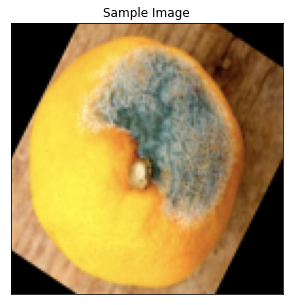

In [5]:
# a function to display image
def showImage(img):
    img = np.float32(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(5,5))
    plt.imshow(img, vmin=0, vmax=255), plt.title('Sample Image')
    plt.xticks([]), plt.yticks([]), plt.show()

# randomly select an image from training images to display
idx = random.randint(0, len(X_train))
showImage(X_train[idx, :])

## Convolution Neural Network Model
Build DenseNet Model

In [7]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(8, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


MobileNetV2

In [8]:
MobileNetV2_base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

x = MobileNetV2_base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(8, activation='softmax')(x)

MV2_model = Model(inputs=MobileNetV2_base_model.input, outputs=predictions)

for layer in MobileNetV2_base_model.layers:
    layer.trainable = False

MV2_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

In [6]:
# stop training when the validation loss is increasing for three epochs
callback = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                         patience=3, 
                                         restore_best_weights=True)

dense model

In [10]:
# train model
history = model.fit(X_train, y_train, 
                    epochs=100, 
                    batch_size=32, 
                    validation_data=(X_test, y_test),
                    callbacks=[callback])

Epoch 1/100
392/392 [==============================] - 303s 757ms/step - loss: 0.2139 - accuracy: 0.9284 - val_loss: 0.0699 - val_accuracy: 0.9760
Epoch 2/100
392/392 [==============================] - 289s 739ms/step - loss: 0.0516 - accuracy: 0.9811 - val_loss: 0.0419 - val_accuracy: 0.9849
Epoch 3/100
392/392 [==============================] - 288s 736ms/step - loss: 0.0353 - accuracy: 0.9887 - val_loss: 0.0890 - val_accuracy: 0.9781
Epoch 4/100
392/392 [==============================] - 289s 737ms/step - loss: 0.0354 - accuracy: 0.9872 - val_loss: 0.0334 - val_accuracy: 0.9917
Epoch 5/100
392/392 [==============================] - 290s 741ms/step - loss: 0.0164 - accuracy: 0.9950 - val_loss: 0.0258 - val_accuracy: 0.9914
Epoch 6/100
392/392 [==============================] - 289s 736ms/step - loss: 0.0324 - accuracy: 0.9903 - val_loss: 0.0568 - val_accuracy: 0.9852
Epoch 7/100
392/392 [==============================] - 288s 735ms/step - loss: 0.0267 - accuracy: 0.9914 - val_loss: 0

mv2 model

In [11]:
# train model
history = MV2_model.fit(X_train, y_train, 
                    epochs=100, 
                    batch_size=32, 
                    validation_data=(X_test, y_test),
                    callbacks=[callback])

Epoch 1/100
392/392 [==============================] - 96s 239ms/step - loss: 0.1839 - accuracy: 0.9367 - val_loss: 0.0900 - val_accuracy: 0.9658
Epoch 2/100
392/392 [==============================] - 87s 223ms/step - loss: 0.0542 - accuracy: 0.9801 - val_loss: 0.0394 - val_accuracy: 0.9846
Epoch 3/100
392/392 [==============================] - 88s 225ms/step - loss: 0.0146 - accuracy: 0.9959 - val_loss: 0.0529 - val_accuracy: 0.9837
Epoch 4/100
392/392 [==============================] - 88s 225ms/step - loss: 0.0185 - accuracy: 0.9939 - val_loss: 0.0746 - val_accuracy: 0.9729
Epoch 5/100
392/392 [==============================] - 89s 226ms/step - loss: 0.0320 - accuracy: 0.9897 - val_loss: 0.0850 - val_accuracy: 0.9794


In [17]:
#save model

model.save('densenet_classifycondition_model')

INFO:tensorflow:Assets written to: densenet_classifycondition_model\assets


INFO:tensorflow:Assets written to: densenet_classifycondition_model\assets


In [18]:
MV2_model.save('MV2_classifycondition')

INFO:tensorflow:Assets written to: MV2_classifycondition\assets


INFO:tensorflow:Assets written to: MV2_classifycondition\assets


- Show Loss and Accuracy

Mobile net v2 model

102/102 - 17s - loss: 0.0394 - accuracy: 0.9846 - 17s/epoch - 171ms/step
MobileNetV2 model Evaluation result on testing dataset : Loss = 0.039444901049137115, Accuracy = 0.9845964312553406


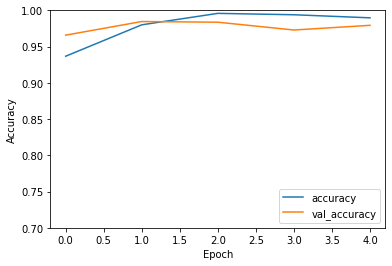

In [14]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.7, 1])
plt.legend(loc='lower right')

test_loss, test_acc = MV2_model.evaluate(X_test,  y_test, verbose=2)
print("MobileNetV2 model Evaluation result on testing dataset : Loss = {}, Accuracy = {}".format(test_loss, test_acc))
plt.show()

DenseNet model

102/102 - 64s - loss: 0.0258 - accuracy: 0.9914 - 64s/epoch - 631ms/step
DenseNet Model Evaluation result on testing dataset : Loss = 0.02583962120115757, Accuracy = 0.9913740158081055


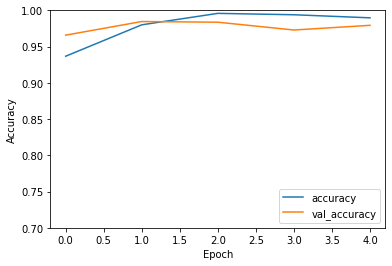

In [15]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.7, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)
print("DenseNet Model Evaluation result on testing dataset : Loss = {}, Accuracy = {}".format(test_loss, test_acc))
plt.show()

In [19]:
# load model dense net
test_model = keras.models.load_model('densenet_classifycondition_model')

In [20]:
mv2test_model = keras.models.load_model('MV2_classifycondition')

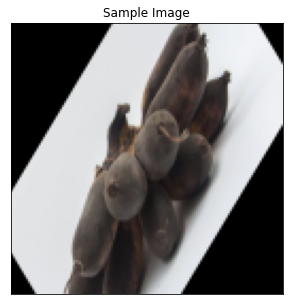

1/1 [==============================] - 0s 181ms/step
Actual class: rotten banana
Predicted class: rotten banana


In [24]:
# Define a dictionary to map class indices to class names
class_names = {0: 'fresh apples', 1: 'fresh banana', 2: 'fresh oranges',3:'fresh lime', 4: 'rotten apples', 5: 'rotten banana', 6: 'rotten oranges', 7:'rotten lime'}

# Choose a random test image
idx = np.random.randint(0, len(y_test))

# Show the image using a custom function
showImage(X_test[idx, :])

# Get the actual class name
y_test_class = np.argmax(y_test[idx])
actual = class_names[y_test_class]

# Make a prediction
pred_res = test_model.predict(X_test[idx, :].reshape(1, 128, 128, 3))
pred_class = np.argmax(pred_res)

# Get the predicted class name
pred = class_names[pred_class]

print('Actual class:', actual)
print('Predicted class:', pred)


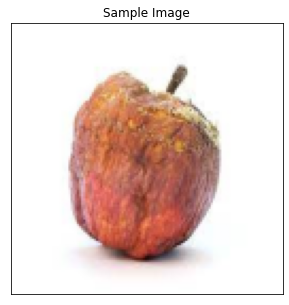

1/1 [==============================] - 0s 76ms/step
Predicted class: rotten apples
[0. 0. 0. 0. 1. 0. 0. 0.]


In [22]:
# load an external image

# path = './dataset/test/freshoranges/rotated_by_15_Screen Shot 2018-06-13 at 12.13.44 AM.png'
path = "rotten apple test.jpeg"
# path = "rotten banana.jpeg"
#path = "rotten oren.jpeg"
# path = "rotten lime.jpg"
for filename in glob.glob(path):
    image = cv2.imread(filename)
    display_img = cv2.resize(image, (128, 128), interpolation=cv2.INTER_AREA)
    display_img = display_img/255.0
    
showImage(display_img)

# resize image to match model input shape
image = cv2.resize(image, (128, 128))
image = img_to_array(image)
image = image/255.0
image = np.expand_dims(image, axis=0)

# make predictions using your trained model
pred_res = test_model.predict(image)

# convert prediction to one hot encoding
pred_res = np.eye(8)[np.argmax(pred_res, axis=1)[0]]

# map class index to class label
if (pred_res[0] == 1):
    pred = 'fresh apples'
elif (pred_res[1] == 1):
    pred = 'fresh banana'
elif (pred_res[2] == 1):
    pred = 'fresh oranges'
elif (pred_res[3] == 1):
    pred = 'fresh lime'
elif (pred_res[4] == 1):
    pred = 'rotten apples'
elif (pred_res[5] == 1):
    pred = 'rotten banana'
elif (pred_res[6] == 1):
    pred = 'rotten oranges'
elif (pred_res[7] == 1):
    pred = 'rotten lime'

else:
    pred = 'error'

print('Predicted class:', pred)
print(pred_res)

convert to tensorflow lite

In [27]:
import tensorflow as tf

# Load your Keras model
model = tf.keras.models.load_model('MV2_classifycondition')
# model = tf.keras.models.load_model('densenet_classifycondition_model')


# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
with open('mv2classifycon.tflite', 'wb') as f:
# with open('denseclassifycon.tflite', 'wb') as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\FORGE-~1\AppData\Local\Temp\tmpl5b814ha\assets


INFO:tensorflow:Assets written to: C:\Users\FORGE-~1\AppData\Local\Temp\tmpl5b814ha\assets


tensorflow lite model

In [26]:
import numpy as np
import tensorflow as tf
from PIL import Image

# Load TFLite model and allocate tensors.
# interpreter = tf.lite.Interpreter(model_path="mv2classifycon.tflite")
interpreter = tf.lite.Interpreter(model_path="denseclassifycon.tflite")
interpreter.allocate_tensors()

# Load and preprocess the image
image = Image.open('rotten lime.jpeg').resize((128, 128))
image_data = np.expand_dims(np.array(image) / 255.0, axis=0)
print("image data ",image_data)
image_data = image_data.astype(np.float32)

# print("image data ",image_data)


# Set the input tensor
input_details = interpreter.get_input_details()
print(f'input_details : {input_details}')
interpreter.set_tensor(input_details[0]['index'], image_data)
print('INPUT DETAILS =',input_details[0]['index'])
print('INPUT DETAILS =',input_details[0])


# Run inference
interpreter.invoke()

# Get the output tensor
output_details = interpreter.get_output_details()
output_data = interpreter.get_tensor(output_details[0]['index'])
print('out put data:',output_data)
predicted_class_index = np.argmax(output_data)
print(predicted_class_index)

# Print the signatures from the converted model
signatures = interpreter.get_signature_list()
print('Signature:', signatures)


# Map the predicted class index to a class name
class_names = {
    0: 'fresh apples',
    1: 'fresh banana',
    2: 'fresh oranges',
    3: 'fresh lime',
    4: 'rotten apples',
    5: 'rotten banana',
    6: 'rotten oranges',
    7: 'rotten lime'
}
predicted_class_name = class_names[predicted_class_index]

print(f'Predicted class: {predicted_class_name}')


image data  [[[[0.96078431 0.97254902 0.94509804]
   [0.97254902 0.98431373 0.95686275]
   [0.96862745 0.98039216 0.95294118]
   ...
   [0.90588235 0.91372549 0.89411765]
   [0.90588235 0.91372549 0.89411765]
   [0.90196078 0.90980392 0.89019608]]

  [[0.96470588 0.97647059 0.94901961]
   [0.96862745 0.98039216 0.95294118]
   [0.96862745 0.98039216 0.95294118]
   ...
   [0.92156863 0.92941176 0.90980392]
   [0.91764706 0.9254902  0.90588235]
   [0.90196078 0.90980392 0.89019608]]

  [[0.98039216 0.99215686 0.96470588]
   [0.97647059 0.98823529 0.96078431]
   [0.96470588 0.97647059 0.94901961]
   ...
   [0.9254902  0.93333333 0.91372549]
   [0.9254902  0.93333333 0.91372549]
   [0.90980392 0.91764706 0.89803922]]

  ...

  [[0.54117647 0.54901961 0.50588235]
   [0.56078431 0.56862745 0.5254902 ]
   [0.55686275 0.56470588 0.52156863]
   ...
   [0.85882353 0.85882353 0.81960784]
   [0.85882353 0.85882353 0.82745098]
   [0.8627451  0.8627451  0.83137255]]

  [[0.5372549  0.54509804 0.50196

In [ ]:
pip install tflite


In [ ]:
pip install protobuf==3.20


In [ ]:
import os
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'

DenseNet model


In [ ]:

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.7, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)
print("Evaluation result on testing dataset : Loss = {}, Accuracy = {}".format(test_loss, test_acc))
plt.show()